<center>
<h1><br/></h1>
<h1>INF 582: Introduction To Text Mining And NLP</h1>
<h2>Challenge: News Articles Title Generation</h2>
<h3>Notebook: Fine-Tuning the 3rd model: mT5_multilingual_XLSum</h3>
<h4>Students Name: <br>
<b>DABERE Abasse<br>
FUERTES PANIZO Cynthia Yacel</b> </h4>
<br>
</center>

# `Fine-Tuning mT5_multilingual_XLSum`


In [ ]:
MODEL_NAME = 'csebuetnlp/mT5_multilingual_XLSum'

In [ ]:
%pip install -q -U bitsandbytes
%pip install -q -U git+https://github.com/huggingface/transformers.git
%pip install -q -U git+https://github.com/huggingface/peft.git
%pip install -q -U git+https://github.com/huggingface/accelerate.git
%pip install -q datasets

In [ ]:
# Libraries for data analysis and visualization
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

# Deep learning and natural language processing
import torch
torch.cuda.empty_cache()  # Clears CUDA cache
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import TrainingArguments, Trainer
import datasets

# Utilities and text preprocessing
from tqdm import tqdm
import re

# Model evaluation and custom models
from rouge_score import rouge_scorer
from peft import LoraConfig, TaskType, get_peft_model

/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-30 18:19:02.904386: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-30 18:19:02.924441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 18:19:02.924470: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
path = 'data/'

with_corrected_text = True # Set to True to use the corrected text for training
train_path = path + 'train_grammar_correction.csv' if with_corrected_text else path + 'train.csv'

train_df = pd.read_csv(train_path)
validation_df = pd.read_csv(path + 'validation.csv')
test_df = pd.read_csv(path + 'test_text.csv')

print(f'Loaded {len(train_df)} samples for training')
print(f'Loaded {len(validation_df)} samples for validation')
print(f'Loaded {len(test_df)} samples for testing')

Loaded 21401 samples for training
Loaded 1500 samples for validation
Loaded 1500 samples for testing


In [ ]:
# rouge score
scorer = rouge_scorer.RougeScorer(['rougeL'])

def calculate_rouge_score(reference, generated):
    rouge_score = scorer.score(generated, reference)['rougeL'][2]
    return rouge_score

## `1 Base Model`


In [ ]:
WHITESPACE_HANDLER = lambda k: re.sub('\s+', ' ', re.sub('\n+', ' ', k.strip()))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
base_model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME).to(device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/users/ele

## `2 DATA PREPARATION`


In [ ]:
max_text_length = 512
max_title_length = 155

In [ ]:
def tokenize_function(examples):
    tokenizer_inputs = tokenizer(
        [WHITESPACE_HANDLER(text) for text in examples['text']],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=max_text_length,
    )
    if 'titles' in examples:
        tokenizer_inputs['labels'] = tokenizer(
            examples['titles'],
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length= max_title_length,
        )['input_ids']
    return tokenizer_inputs

# Tokenize the datasets
train_dataset = datasets.Dataset.from_pandas(train_df)
validation_dataset = datasets.Dataset.from_pandas(validation_df)
test_dataset = datasets.Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
validation_dataset = validation_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 1500/1500 [00:00<00:00, 3837.90 examples/s]


## `3 Test the Base Model`


In [ ]:
def generate_titles(model, tokenizer, N=200, batch_size = 8, max_length=64, num_beams=8, no_repeat_ngram_size=4):
    # generate titles for train
    generated_train_titles = []
    for i in tqdm(range(0, N, batch_size)):
        batch = train_dataset[i:i+batch_size]
        output_ids = model.generate(
            input_ids = torch.tensor(batch['input_ids']).to(device),
            num_beams= num_beams,
            max_length= max_length,
            no_repeat_ngram_size= no_repeat_ngram_size,
        )
        generated_titles = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        generated_train_titles.extend(generated_titles)

    # generate titles for validation
    generated_validation_titles = []
    for i in tqdm(range(0, N, batch_size)):
        batch = validation_dataset[i:i+batch_size]
        output_ids = model.generate(
            input_ids = torch.tensor(batch['input_ids']).to(device),
            num_beams= num_beams,
            max_length= max_length,
            no_repeat_ngram_size= no_repeat_ngram_size,
        )
        generated_titles = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        generated_validation_titles.extend(generated_titles)

    return generated_train_titles, generated_validation_titles

def generate_test_titles(model, tokenizer, N=len(test_dataset), batch_size = 8, max_length=64, num_beams=8, no_repeat_ngram_size=4):
    # generate titles for test
    generated_test_titles = []
    for i in tqdm(range(0, N, batch_size)):
        batch = test_dataset[i:i+batch_size]
        output_ids = model.generate(
            input_ids = torch.tensor(batch['input_ids']).to(device),
            num_beams= num_beams,
            max_length= max_length,
            no_repeat_ngram_size= no_repeat_ngram_size,
        )
        generated_titles = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        generated_test_titles.extend(generated_titles)

    return generated_test_titles

def calculate_rouge(generated_train_titles, generated_validation_titles):
    # rouge score for train
    train_rouge_scores = []
    N = len(generated_train_titles)
    for i in tqdm(range(N)):
        rouge_score = calculate_rouge_score(train_df['titles'][i], generated_train_titles[i])
        train_rouge_scores.append(rouge_score)
    avg_train_rouge_score = sum(train_rouge_scores) / len(train_rouge_scores)

    # rouge score for validation
    validation_rouge_scores = []
    N = len(generated_validation_titles)
    for i in tqdm(range(N)):
        rouge_score = calculate_rouge_score(validation_df['titles'][i], generated_validation_titles[i])
        validation_rouge_scores.append(rouge_score)
    avg_validation_rouge_score = sum(validation_rouge_scores) / len(validation_rouge_scores)

    return avg_train_rouge_score, avg_validation_rouge_score

# Store the generated summaries in the Kaggle-accepted format
def generate_submission_df(generated_test_titles):
    submission_df = pd.DataFrame({
        'ID': test_df['ID'],
        'titles': generated_test_titles,
    })
    submission_df.to_csv('results/' + path.split('/')[0] + '#' + path.split('/')[1] + '#' + path.split('/')[2] + '.csv', index=False)
    return submission_df

In [ ]:
# generate titles for train and validation
generated_train_titles, generated_validation_titles = generate_titles(
    base_model,
    tokenizer,
    N=200,
    batch_size=8,
    max_length=155,
    num_beams=4,
    no_repeat_ngram_size=4
)

100%|██████████| 25/25 [00:42<00:00,  1.69s/it]


In [ ]:
# calculate rouge score for train and validation
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)

print('Average Rouge Score for Train:', avg_train_rouge_score)
print('Average Rouge Score for Validation:', avg_validation_rouge_score)

100%|██████████| 200/200 [00:00<00:00, 6608.33it/s]

Average Rouge Score for Train: 0.18991898489158873
Average Rouge Score for Validation: 0.21462337174256463


## `2 PEFT with LORA`


In [ ]:
task_type = TaskType.SEQ_2_SEQ_LM
lora_rank = 64
learning_rate = 1e-3
weight_decay = 0.01
lora_alpha = 32
lora_dropout = 0.1
target_modules = ['q', 'k', 'v', 'o']

num_epochs = 50
batch_size = 8

output_dir = f'mT5_multilingual_XLSum/mt{max_text_length}-ms{max_title_length}-lora{lora_rank}' + ('-tgc/' if with_corrected_text else '/')

In [ ]:
peft_config = LoraConfig(
    task_type=task_type,
    inference_mode=False,
    target_modules= target_modules,
    r= lora_rank,
    lora_alpha= lora_alpha,
    lora_dropout= lora_dropout,
    )

peft_model = get_peft_model(base_model, peft_config).to(device)
peft_model.print_trainable_parameters()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


trainable params: 14,155,776 || all params: 596,557,056 || trainable%: 2.372912340508801


In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    weight_decay=weight_decay,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
    tokenizer=tokenizer,
)

/users/eleves-a/2021/abasse.dabere/.local/lib/python3.9/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


- fine-tune the model


In [ ]:
# trainer.train()

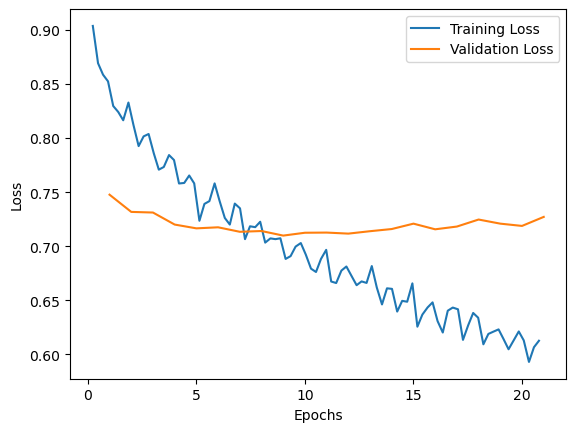

In [ ]:
last_checkpoint = # TODO: Set the last checkpoint manually

with open(f'{output_dir}checkpoint-{last_checkpoint}/trainer_state.json') as f:
    training_state = json.load(f)

log_history = training_state['log_history']
# plot the training loss and validation loss over the epochs
epochs_loss = [(log['epoch'], log['loss']) for log in log_history if 'loss' in log]
epochs_val_loss = [(log['epoch'], log['eval_loss']) for log in log_history if 'eval_loss' in log]

plt.plot(*zip(*epochs_loss), label='Training Loss')
plt.plot(*zip(*epochs_val_loss), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## `3 Test Fine-Tuned Model`


In [ ]:
# checkpoint
# TODO: Choose a checkpoint manually
checkpoint = 21410

path_checkpoint = f'{output_dir}checkpoint-{checkpoint}'

In [ ]:
checkpoint_model = AutoModelForSeq2SeqLM.from_pretrained(path_checkpoint).to(device)

In [ ]:
# generate titles for train and validation
generated_train_titles, generated_validation_titles = generate_titles(
    checkpoint_model,
    tokenizer,
    N=500,
    batch_size=8,
    max_length=max_title_length,
    num_beams=4,
    no_repeat_ngram_size=4
)

# calculate rouge score for train and validation
avg_train_rouge_score, avg_validation_rouge_score = calculate_rouge(generated_train_titles, generated_validation_titles)

print('Average Rouge Score for Train:', avg_train_rouge_score)
print('Average Rouge Score for Validation:', avg_validation_rouge_score)

100%|██████████| 504/504 [00:00<00:00, 5378.37it/s]

Average Rouge Score for Train: 0.30885794528728966
Average Rouge Score for Validation: 0.2371748842216963


In [ ]:
# generate titles for test
generated_test_titles = generate_test_titles(
    checkpoint_model,
    tokenizer,
    N=len(test_dataset),
    batch_size=8,
    max_length=max_title_length,
    num_beams=4,
    no_repeat_ngram_size=4
)

submission_df = generate_submission_df(generated_test_titles)

## `4` Continue to fine-tune


In [ ]:
# training_args = TrainingArguments(
#     output_dir=output_dir,
#     learning_rate=learning_rate,
#     per_device_train_batch_size=batch_size,
#     per_device_eval_batch_size=batch_size,
#     num_train_epochs=num_epochs,
#     weight_decay=weight_decay,
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     load_best_model_at_end=True,
#     resume_from_checkpoint= # TODO: resume training from the last checkpoint
# )

# trainer = Trainer(
#     model=peft_model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=validation_dataset,
#     tokenizer=tokenizer,
# )

In [ ]:
# continue training
# trainer.train()